# Transport Equation Solver with Fourier Transform

In this notebook, we implement the numerical solver of the transport equation
$\begin{equation}\frac{\partial \rho}{\partial t} + \frac{\partial (\rho v)}{\partial x} = 0 \end{equation} \tag*{}$
 on $(t,x)\in [0,1]\times [0,L]$ for a given $v:[0,1]\times [0,L]\to \mathbb{R}$ with a periodic boundary using the discrete Fourier transform. In addition, we implement the calculation of the Wasserstein energy consistent with this method. This notebook is available at https://github.com/mao1756/pdot.

In [64]:
# Import relevant libraries

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

**For comparison, we first solve the problem without the Fourier transform.**

## The Staggered Grid
For the discretization of the time-space rectangle $[0,1]\times [0,L]$, we use the staggered grid, which is known to be more stable for fluid dynamical calculations. Let $N_0$ be the number of time steps and $N_1$ be the number of space steps. We introduce the **centered grid** 
$\begin{equation} \mathcal{G}_c = \left\{\left(\frac{i_0}{N_0}, L\frac{i_1+1/2}{N_1}\right)\middle| i_0= 0,\cdots ,N_0, i_1 = 0,\cdots N_1-1 \right\}.\end{equation} \tag*{}$
and the **space staggered grid**
$\begin{equation} \mathcal{G}_s^x = \left\{\left(\frac{i_0}{N_0}, L\frac{i_1}{N_1}\right)\middle| i_0= 0,\cdots ,N_0, i_1 = 0,\cdots N_1 \right\}\end{equation} \tag*{}$ 

We note that Papadakis et al. (2014) and Chizat et al. (2015) used the **time staggered grid** in addition, but we do not use that here because it does not translate well to our methodology. The main reason it does not work is that they use the momentum $\omega$ as their variable, but here we use the velocity vector field $v$ and find the momentum as $\omega = \rho v$.

# Functions
We define the following:
- $\rho^{c}_{i_0,i_1} = \rho(i_0/(N_0-1), L(i_1+1/2)/N_1)$ : The discretized mass on the centered grid
- $\rho^{sx}_{i_0,i_1} = \rho(i_0/(N_0-1),  Li_1/N_1)$: The discretized velocity mass on the space staggered grid
- $v^{sx}_{i_0,i_1} = v(i_0/(N_0-1),  Li_1/N_1)$: The discretized velocity field on the space staggered grid

The mass on the staggered grids and the one on the centered grids are related as follows:
$\begin{equation}\rho^{sx}_{i_0,i_1} = \frac{\rho^{c}_{i_0,i_1}+\rho^{c}_{i_0,i_1-1}}{2} \end{equation} \tag*{}$
For $i_1=0,N_1$, we use the periodicity to define the right hand side.

In short, we use $\rho^{c}$ and $v^{sx}$ as main variables, and find $\rho^{sx}$ by interpolation.

Finally, we define the staggered variable $U= (\rho^{sx})$ and the centered variable $V = (\rho^{c}, v^{c})$. 

In [239]:
class SVar(): 
    """ Staggered Variable.

    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the space or L (list of L's if higher dimension)
    psx: list of mass on the space staggered grids.
         psx[i] represents the mass on the staggered grid in the i+1 th space dimension.
    vsx: list of vector field on the space staggered grids
          vsx[i] represents the ith element of the velocity field on the staggered frid in the i+1 th space dimension.
    """
    def __init__(self,
                 cs : List[int],
                 ll : List[float]):
        self.cs = cs
        self.ll = ll
        size = [cs[0]+1, *cs[1:]]
        self.psx = [np.zeros(size) for _ in range(1, len(cs))]
        self.vsx = [np.zeros(size) for _ in range(1, len(cs))] 

        # Unnecessary?
        # adds 1 to staggered dimensions
        #pstags = [[cs[i]+1 if i==k else cs[i] for i in range(len(cs))] for k in range(1,len(cs))]
        # append the dimension of the vector or the space
        #vstags = [[cs[i]+1 if i==k else cs[i] for i in range(len(cs))]+[len(self.cs)-1] for k in range(1,len(cs))]
        #self.psx = [np.zeros(size) for size in pstags]
        #self.vsx = [np.zeros(size) for size in vstags]

class CVar():
    """Centered Variable.
    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the space or L (list of L's if higher dimension)
    pc: mass on the centered grid.
    """
    def __init__(self,
                 cs : List[int],
                 ll : List[float]):         
        self.cs = cs
        self.ll = ll
        size = [cs[0]+1, *cs[1:]]
        self.pc = np.zeros(size)

class CSVar():
     """ The pair of the staggered variable and the centered variable.
     The implementation here is done in a D-dimensional space.
     Attributes:
     cs: the grid size (N_0, N_1, ..., N_D)
     ll: the size(s) of the space or L (list of L's if higher dimension)
     U: the staggered variable.
     V: the centered variable.
     """
     def __init__(self,
                 cs : List[int],
                 ll : List[float]):
        self.cs = cs
        self.ll = ll
        self.U = SVar(cs, ll)
        self.V = CVar(cs, ll)

     def interp(self):
        """ Using the centered mass, we find the staggered mass
        """
        for d in range(len(self.cs)-1):
          self.U.psx[d] = (self.V.pc + np.roll(self.V.pc, 1, d+1))/2

## The Discretization of The Transport Equation
We discretize the transport equation
$\begin{equation}\frac{\partial \rho}{\partial t} + \frac{\partial (\rho v)}{\partial x} = 0 \end{equation}\tag*{}$
as follows:
$\begin{equation}\frac{\rho_{i_0+1,i_1}^c-\rho_{i_0,i_1}^c}{\Delta t} + \frac{(\rho v)_{i_0,i_{1}+1}^{sx}-(\rho v)_{i_0,i_1}^{sx}}{\Delta x} = 0\end{equation} \tag*{}$
which gives us the following update rule:
$\begin{equation}\rho_{i_0+1,i_1}^c = \rho_{i_0,i_1}^c - \Delta t \frac{(\rho v)_{i_0,i_{1}+1}^{sx}-(\rho v)_{i_0,i_1}^{sx}}{\Delta x} \tag*{}\end{equation}$

where $\Delta t  = 1/N_0$ and $\Delta x = L/N_0$.

In [262]:
class TransportEquation():
    """ The Transport Equation Solver

    The implementation here is done in a D-dimensional space.
    Attributes:
    cs: the grid size (N_0, N_1, ..., N_D)
    ll: the size(s) of the time/space or L (list of L's if higher dimension)
    L0 = total time, L1 = length of the first space dimension, ...
    var: the variables on the centered and the staggered grids
    """

    def __init__(self,
                 cs: List[int],
                 ll: List[int],
                 p0: np.ndarray,
                 vsx: np.ndarray):
        self.cs = cs
        self.ll = ll
        self.var = CSVar(cs, ll)
        self.var.V.pc[0] = p0
        self.var.interp()
        self.var.U.vsx = vsx
        self.dt = 1./self.cs[0]
        self.dx = np.array(self.ll[1:])/np.array(self.cs[1:])
    
    def solve(self):
        """ Solves the transport equation for the given conditions.
        """
        for i0 in range(self.cs[0]):
            div = sum((np.roll(self.var.U.psx[i][i0]*self.var.U.vsx[i][i0], -1, i) - \
                      self.var.U.psx[i][i0]*self.var.U.vsx[i][i0])/self.dx[i] for i in range(len(self.cs)-1))
            self.var.V.pc[i0+1] = self.var.V.pc[i0] -self.dt*div
            self.var.interp()

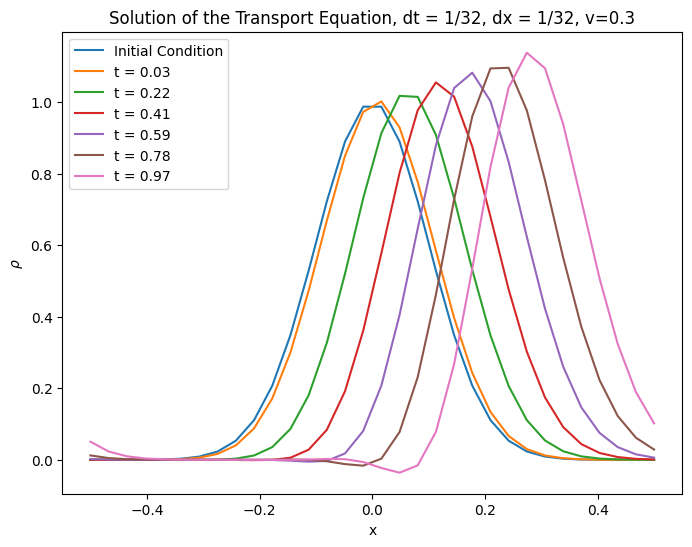

In [281]:
# Setting up the problem
cs = [32, 32]  # [time steps, spatial points]
ll = [1.0, 1.0]  # [total time, spatial domain size]
x = np.linspace(-ll[1]/2, ll[1]/2, cs[1])
size = [cs[0]+1, *cs[1:]]
p0 = np.exp(-50*x**2)
vsx = [0.3*np.ones(size) for _ in range(1, len(cs))]


# Create a TransportEquation instance
transport_eq = TransportEquation(cs, ll, p0, vsx)
# Solve the transport equation
transport_eq.solve()

# Visualization
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, p0, label="Initial Condition")
for i in range(1, cs[0], cs[0]//5):
    ax.plot(x, transport_eq.var.V.pc[i], label=f"t = {ll[0]*i/cs[0]:.2f}")

ax.set_title("Solution of the Transport Equation, dt = 1/32, dx = 1/32, v=0.3")
ax.set_xlabel("x")
ax.set_ylabel(r"$\rho$")
ax.legend()
plt.show()

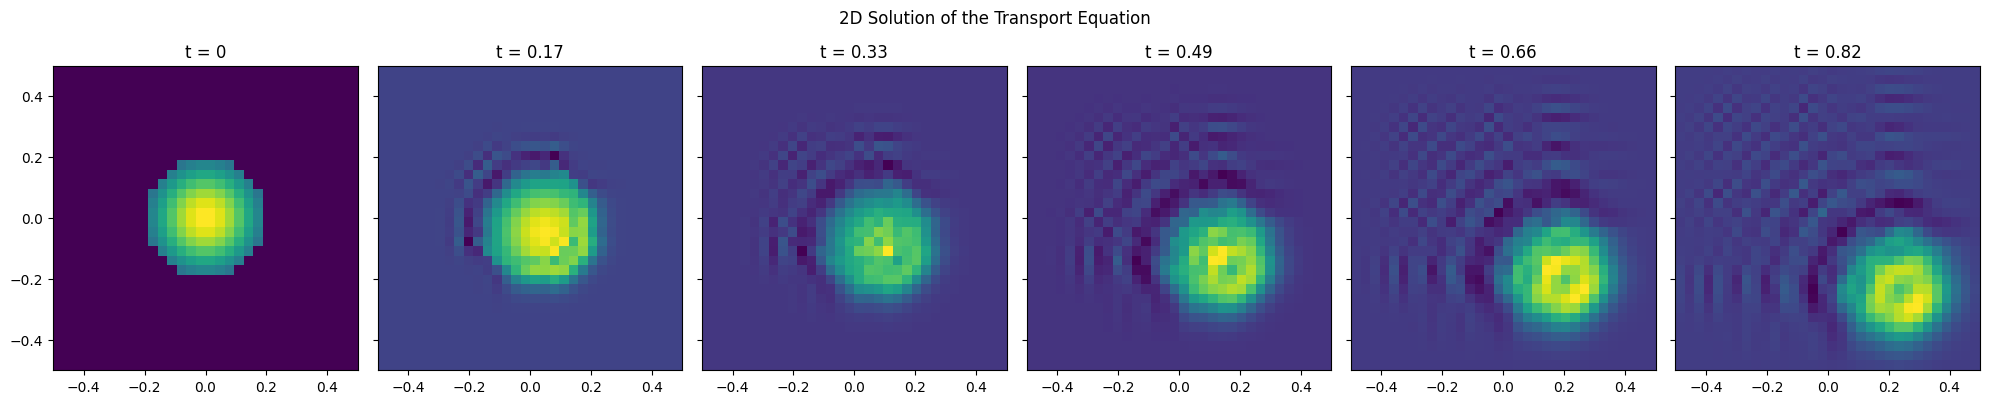

In [289]:
# 2D Circular Bump Example

# Setting up the problem
cs_2d = [200, 32, 32]  # [time steps, x spatial points, y spatial points]
ll_2d = [1.0, 1.0, 1.0]  # [total time, x spatial domain size, y spatial domain size]
x_2d = np.linspace(-ll_2d[1]/2, ll_2d[1]/2, cs_2d[1])
y_2d = np.linspace(-ll_2d[2]/2, ll_2d[2]/2, cs_2d[2])
X, Y = np.meshgrid(x_2d, y_2d)

# Circular bump initial condition
r = 0.2
p0_2d = np.exp(-(X**2 + Y**2)/r**2)
p0_2d[X**2 + Y**2 > r**2] = 0

# Rotating velocity field
#vx = -Y
#vy = X
#vsx_2d = [np.stack([vx, vy], axis=-1)]
size = [cs_2d[0]+1, *cs_2d[1:]]
vsx_2d = [0.3*np.ones(size) for _ in range(1, len(cs_2d))] 

# Create a TransportEquation instance
transport_eq_2d = TransportEquation(cs_2d, ll_2d, p0_2d, vsx_2d)

# Solve the transport equation
transport_eq_2d.solve()

# Visualization
fig_2d, axs_2d = plt.subplots(1, 6, figsize=(20,4), sharex=True, sharey=True)
axs_2d[0].imshow(p0_2d, extent=[-ll_2d[1]/2, ll_2d[1]/2, -ll_2d[2]/2, ll_2d[2]/2])
axs_2d[0].set_title("t = 0")

for i, ax in enumerate(axs_2d[1:], 1):
    idx = i * (cs_2d[0] // 6)
    ax.imshow(transport_eq_2d.var.V.pc[idx], extent=[-ll_2d[1]/2, ll_2d[1]/2, -ll_2d[2]/2, ll_2d[2]/2])
    ax.set_title(f"t = {ll_2d[0]*idx/cs_2d[0]:.2f}")

fig_2d.suptitle("2D Solution of the Transport Equation")
plt.tight_layout()
plt.show()